<a href="https://colab.research.google.com/github/stanislawcronberg/Numpy-Practice-Projects/blob/main/Simplified_SVM_with_Numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementing a simplified SVM with Numpy from scratch

1. Problem statement
2. Point selection algorithm
3. 2D Case
    - Example 2D data
    - Criteria for support vectors in 2D
    - 2D Implementation
4. 3D Case
    - Example 3D data
    - Criteria for support vectors in 3D 
    - 3D Implementation

### 1. Problem Statement

We first build a Maximal Margin Classifier. The conditions are:
- Minimize $\frac{1}{2}w^Tw$
- Subject to $(w^Tx^{(i)} + b) = 1$ for $i = 1, ..., \text{n_dimensions + 1}$

### Sample Dataset for 2D Case

$X$ contains our matrix of points, whereas $y$ contains a vector of their corresponding label.
- Where $y \in \{-1, 1\}$ and $x \in R^2$

In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()

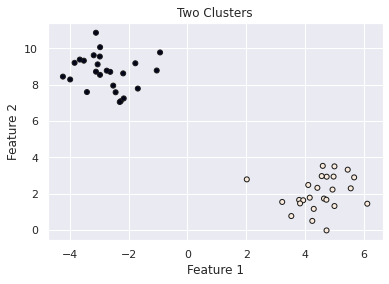

In [2]:
from sklearn.datasets import make_blobs

# Our sample cluster data
X, y = make_blobs(n_features=2, centers=2, random_state=42, n_samples=50)

# Changing negative y class from 0 to -1
y[y == 0] = -1

plt.scatter(X[:, 0], X[:, 1],marker='o', c=y,
            s=25, edgecolor='k')
plt.title('Two Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### Point Selection Algorithm
- We make use of the `combinations()` function from the `itertools` package in order to generate all possible groups of points we want to consider
- Works for both the 2D and the 3D case of the algorithm we want to implement 

In [3]:
from itertools import combinations

def get_combinations(X):
    """
    X -> (n_inputs, n_dimensions) numpy.ndarray
    Returns a numpy.darray of possible combinations of indices
    """

    # How many points we have to choose from
    n_points = X.shape[0]

    # How large we want our groups of candidate support vectors to be
    # (n_dimensions + 1)
    group_size = X.shape[1] + 1

    return np.array(list(combinations(range(n_points), group_size)))

For any group of three support vectors that we select we require that:
1. They do not all belong to the same class
2. They do not lie on the same line


In [4]:
def get_vector_from_points(a, b):
    """
    Returns the vector going from point a -> b
    """
    return b-a

In [5]:
def are_supports_legal_2d(index_list, X, y) -> bool:
    """
    Checks if the points are not all from the same class
    Ensure that the support vectors are not collinear

    (All inputs are of type numpy.ndarray)
    index_list -> list of our indices to our points (1, 3)
    X          -> coordinates of our points (num_points, 2)
    y          -> classes of our points (num_points, 1)
    """
    # Get our list of classes
    classes = y[index_list]

    # Check if elements are from the same class
    if np.unique(classes).size == 1:
        return False

    # Get points
    points = X[index_list, :]

    # Create two vectors from our points
    v1 = get_vector_from_points(points[0], points[1])
    v2 = get_vector_from_points(points[1], points[2])

    # Test if the two vectors are linearly independent
    if np.linalg.det(np.vstack([v1, v2])) == 0:
        return False

    return True

In [ ]:
x1 = np.array([1, 1])
x2 = np.array([2, 2])
x3 = np.array([3, 3])

In [ ]:
index = [0, 1, 2]
b = np.vstack([x1, x2, x3, x2, x3, x1])
b[index, :][2]

array([3, 3])

In [ ]:
x = [(1, 2, 3), (0, 5, 6), (2, 4, 6), (6, 4, 3)]
x = np.array(x)
x

array([[1, 2, 3],
       [0, 5, 6],
       [2, 4, 6],
       [6, 4, 3]])

In [ ]:
np.argmin(x, axis=0)[2]

0

In [11]:
a = [1, 2, 3]
np.dot(a, a)

14

In [42]:
class SVM_2d():
    def __init__(self, weights, b):
        self.weights = weights
        self.b = b

    def predict(self, x):
        class_ =  1 if (np.dot(self.weights, x) + self.b > 0) else -1
        return class_

In [43]:
def calculate_svm_2d(indices, X, y):
    # w1 * X[indices[0]][0] + w2*X[indices[0]][1] + b = y[indices[0]]
    # w1 * X[indices[1]][0] + w2*X[indices[1]][1] + b = y[indices[1]]
    # w1 * X[indices[2]][0] + w2*X[indices[2]][1] + b = y[indices[2]]
    
    # Getting our points and their classes for current set 
    # of indices
    y_idx = y[indices]
    X_idx = X[indices]

    # Creating our matrix to solve the system of equations
    bias_col = np.ones(3).reshape(3, 1)
    A = np.concatenate([X[indices], bias_col], axis=1)

    # Solving the system of equations
    # A_inv = np.linalg.inv(A)
    w_b_mat = np.linalg.solve(A, y_idx)

    # Getting our coefficients 
    # w1 = w_b_mat[0]
    # w2 = w_b_mat[1]
    weights = w_b_mat[0:2]
    b = w_b_mat[2]

    # Create svm
    svm = SVM_2d(weights, b)

    # Check if svm is valid
    for sample, target in zip(X, y):
        if svm.predict(sample) != target:
            return None, None


    return weights, b

In [44]:
def calculate_error(w, b, X, y):
    """
    Returns the value we are trying to minimize
    """
    return np.linalg.norm(w)

In [39]:
from tqdm import tqdm

In [45]:
def find_best_svm_2d(X, y) -> tuple:
    """
    Takes our points in 2d and finds the best SVM with
    a maximal margin classifier

    X : matrix of our points     - ndarray (n_points, n_dim)
    y : vector with class labels - ndarray (n_points,)
    """
    # All possible index combinations (not all legal)
    index_choices = get_combinations(X)

    # List to store our history of errors
    # - Needed to later find which combination
    #   of support vectors minimized the error
    wb_error = []

    # Checking each possible group of support vectors
    for index_group in tqdm(index_choices):

        # Checking if not all supports are the same label
        #   or if they are collinear. Then we are allowed 
        #   to skip this group if that's the case
        if not are_supports_legal_2d(index_group, X, y):
            continue
        
        # If our supports are legal then we attempt to 
        #   calculate w and b
        w, b = calculate_svm_2d(index_group, X, y)

        # It's possible that the supports do not find 
        #   an SVM and in that case we continue to look
        #   at the next group of supports
        if (w is None or b is None):
            continue

        # If we managed to find a SVM that works, we 
        #   calculate the error
        error = calculate_error(w, b, X, y)

        # We store the error for this SVM
        #   Note that we need to unpack 'w' as it is a tuple
        wb_error.append([*w, b, error])

    # Converting error to a ndarray to get access to the 
    #   argmin function
    wb_error = np.array(wb_error)

    # Finding the minimal entry in the last column of our
    #   error array.     
    best_index_group = np.argmin(wb_error, axis=0)[-1]
    best_svm = wb_error[best_index_group]

    weights = best_svm[0:2]
    b, error = best_svm[2], best_svm[3]

    return SVM_2d(weights, b), error

In [46]:
svm, error = find_best_svm_2d(X, y)
print()
print("Error: ", round(error, 2))
print("W1:", round(svm.weights[0], 2), "\nW2:", round(svm.weights[1], 2), "\nb:", round(svm.b, 2))

100%|██████████| 19600/19600 [00:03<00:00, 6508.15it/s]


Error:  0.15
W1: 0.11 
W2: -0.1 
b: 0.48


### 3D Maximal Margin Classier

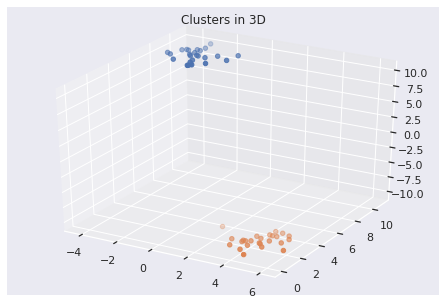

In [120]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors

# Our sample cluster data
n_samples = 50

# Generating 2D data which will have to receive an extra dimension of data
X, y = make_blobs(n_features=2, centers=2, random_state=42, n_samples=n_samples)

# Reshaping y so it works with np.concatenate()
y = y.reshape(50, 1)

# Changing negative y class from 0 to -1
y[y == 0] = -1

# Creating our extra dimension of data
new_val = 10
new_col_top = np.ones(n_samples//2) * new_val
new_col_bot = np.ones(n_samples//2) * new_val * (-1)
new_col = np.concatenate([new_col_top, new_col_bot], axis=0).reshape(n_samples,1)

# Inserting our new dimension of data in place of the labels column, and
# expanding the matrix of all data
mat = np.concatenate([X, y], axis=1)
mat = mat[mat[:,2].argsort()]
mat3 = np.concatenate([mat[:,:2], new_col, mat[:, 2].reshape(n_samples, 1)], axis=1)

# Plotting data
fig = plt.figure()
ax = Axes3D(fig)
half = n_samples // 2
ax.scatter(mat3[:half,0], mat3[:half,1], mat3[:half,2])
ax.scatter(mat3[-half:,0], mat3[-half:,1], mat3[-half:,2])
plt.title('Clusters in 3D')

plt.show()

In [121]:
# From our data generation we now have that
X = mat3[:, :3]
y = mat3[:, 3]

In [122]:
def are_supports_legal_3d(index_list, X, y) -> bool:
    """
    Checks if the points are not all from the same class
    Ensure that the support vectors are not collinear

    (All inputs are of type numpy.ndarray)
    index_list -> list of our indices to our points (1, 4)
    X          -> coordinates of our points (num_points, 3)
    y          -> classes of our points (num_points, 1)
    """
    # Get our list of classes
    classes = y[index_list]

    # Check if elements are from the same class
    if np.unique(classes).size == 1:
        return False

    # Get points
    points = X[index_list, :]

    # Create two vectors from our points
    v1 = get_vector_from_points(points[0], points[1])
    v2 = get_vector_from_points(points[1], points[2])
    v3 = get_vector_from_points(points[2], points[3])

    # Test if the two vectors are linearly independent
    if np.linalg.det(np.vstack([v1, v2, v3])) == 0:
        return False

    return True

In [123]:
class SVM_3d():
    def __init__(self, weights, b):
        self.weights = weights
        self.b = b

    def predict(self, x):
        class_ = 1 if (np.dot(self.weights, x) + self.b > 0) else -1
        return class_

In [134]:
def calculate_svm_3d(indices, X, y):
    
    # Getting our points and their classes for current set 
    # of indices
    X_idx = X[indices]
    y_idx = y[indices]

    # Creating our matrix to solve the system of equations
    bias_col = np.ones(4).reshape(4, 1)
    A = np.concatenate([X[indices], bias_col], axis=1)

    # Solving the system of equations
    w_b_mat = np.linalg.solve(A, y_idx)

    # Getting our coefficients 
    weights = w_b_mat[0:3]
    b = w_b_mat[3]

    # Create svm
    svm = SVM_3d(weights, b)

    # Check if svm is valid
    for sample, target in zip(X, y):
        if svm.predict(sample) != target:
            return None, None


    return weights, b

In [125]:
def find_best_svm_3d(X, y) -> tuple:
    """
    Takes our points in 2d and finds the best SVM with
    a maximal margin classifier

    X : matrix of our points     - ndarray (n_points, n_dim)
    y : vector with class labels - ndarray (n_points,)
    """
    # All possible index combinations (not all legal)
    index_choices = get_combinations(X)

    # List to store our history of errors
    # - Needed to later find which combination
    #   of support vectors minimized the error
    wb_error = []

    # Checking each possible group of support vectors
    for index_group in tqdm(index_choices):

        # Checking if not all supports are the same label
        #   or if they are collinear. Then we are allowed 
        #   to skip this group if that's the case
        if not are_supports_legal_3d(index_group, X, y):
            continue
        
        # If our supports are legal then we attempt to 
        #   calculate w and b
        w, b = calculate_svm_3d(index_group, X, y)

        # It's possible that the supports do not find 
        #   an SVM and in that case we continue to look
        #   at the next group of supports
        if (w is None or b is None):
            continue

        # If we managed to find a SVM that works, we 
        #   calculate the error
        error = calculate_error(w, b, X, y)

        # We store the error for this SVM
        #   Note that we need to unpack 'w' as it is a tuple
        wb_error.append([*w, b, error])

    # Converting error to a ndarray to get access to the 
    #   argmin function
    wb_error = np.array(wb_error)

    # Finding the minimal entry in the last column of our
    #   error array.     
    best_index_group = np.argmin(wb_error, axis=0)[-1]
    best_svm = wb_error[best_index_group]

    weights = best_svm[0:3]
    b, error = best_svm[3], best_svm[4]

    return SVM_3d(weights, b), error

In [126]:
svm, error = find_best_svm_3d(X, y)
print()
print("Error: ", round(error, 2))
print("W1:", round(svm.weights[0], 4), "\nW2:", round(svm.weights[1], 4), "\nW3:", round(svm.weights[2], 4))
print("b:", round(svm.b, 4))

100%|██████████| 230300/230300 [00:47<00:00, 4835.12it/s] 



Error:  0.1
W1: -0.0 
W2: -0.0 
W3: -0.1
b: 0.0


In [133]:
for i in tqdm(range(n_samples)):
    if svm.predict(X[i]) != y[i]:
        print(f'Observation {i} not not correctly predicted')

100%|██████████| 50/50 [00:00<00:00, 16827.02it/s]
